## Read datasets

In [128]:
import pandas as pd
import numpy as np
import os

In [129]:
BTC = pd.read_parquet("BTC-USDT.parquet")
ETH = pd.read_parquet("ETH-USDT.parquet")
BNB = pd.read_parquet("BNB-USDT.parquet")

In [130]:
def _fill_data_dict(dir=os.listdir(), extension=".parquet", func=pd.read_parquet, splitter="-"):
    file_list = [file for file in dir if file.endswith(extension)]
    data_dict = {}
    for file in file_list:
        data_dict[file.split(splitter)[0]] = func(file)
    return data_dict

In [37]:
data_dict = _fill_data_dict()

In [38]:
data_dict

{'BNB':                            open        high         low       close  \
 open_time                                                             
 2017-11-06 03:54:00    1.500000    1.500000    1.500000    1.500000   
 2017-11-06 03:55:00    1.300000    1.300000    1.300000    1.300000   
 2017-11-06 03:56:00    1.300000    1.300000    0.500000    0.500000   
 2017-11-06 03:57:00    0.500000    0.610000    0.500000    0.610000   
 2017-11-06 03:58:00    1.100000    1.100000    1.100000    1.100000   
 ...                         ...         ...         ...         ...   
 2021-02-11 23:36:00  124.051697  124.099403  123.923698  123.974602   
 2021-02-11 23:37:00  123.985298  124.003799  123.813004  123.820396   
 2021-02-11 23:38:00  123.841499  123.952698  123.641502  123.700897   
 2021-02-11 23:39:00  123.770897  123.931396  123.337097  123.884598   
 2021-02-11 23:40:00  123.884598  123.951103  123.635597  123.754402   
 
                           volume  quote_asset_volume  

## Plotting

In [165]:
import matplotlib.pyplot as plt
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30, figsize=(15, 5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='ts', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
        plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

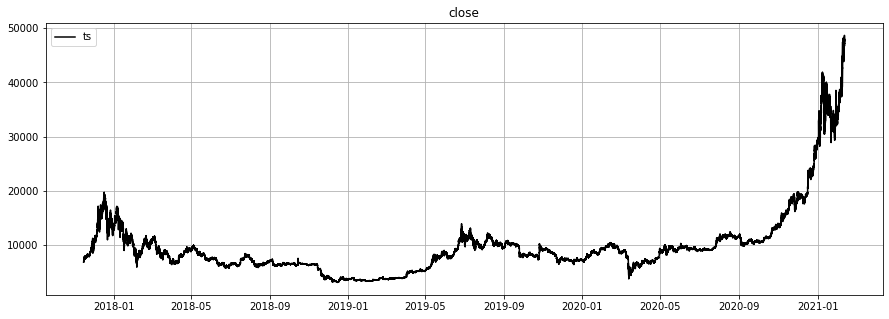

In [166]:
plot_ts(BTC['close'], plot_ma=False, plot_intervals=False, window=60*24*90, figsize=(15,5))

WARNING - (py.warnings._showwarnmsg) - <ipython-input-39-169bf430f585>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")

  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")



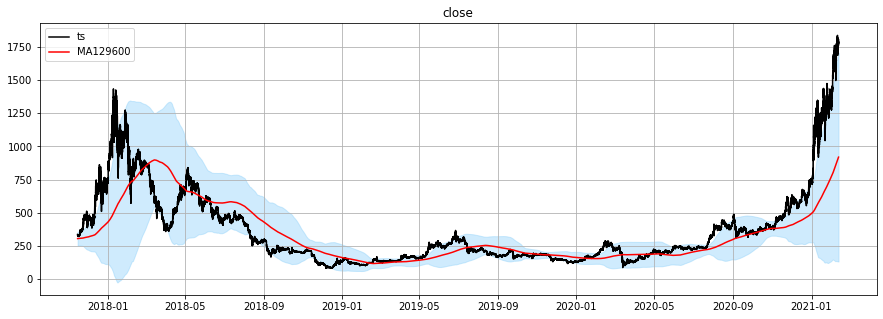

In [41]:
plot_ts(ETH['close'], plot_ma=True, plot_intervals=True, window=60*24*90, figsize=(15,5))

WARNING - (py.warnings._showwarnmsg) - <ipython-input-39-169bf430f585>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")

  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")



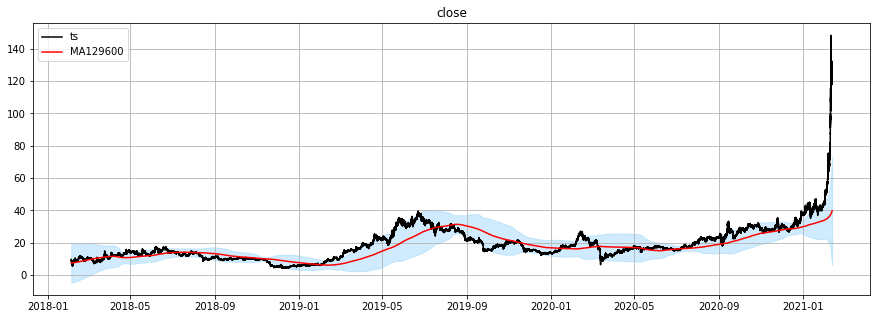

In [42]:
plot_ts(BNB['close'], plot_ma=True, plot_intervals=True, window=60*24*90, figsize=(15,5))

## Preprocessing

In [111]:
data_dict = _fill_data_dict()

### Config
Settings I define which can be varied. Further functions will be dynamically written with respect to these configs

In [112]:
features_aggregation_config = {
    'high': 'max',
    'low': 'min',
    'open': 'first',
    'close': 'last',
    'volume': 'sum',
    'number_of_trades': 'sum',
    'quote_asset_volume': 'sum',
    'taker_buy_base_asset_volume': 'sum',
    'taker_buy_quote_asset_volume': 'sum'
}

features = ['volume'
            , 'high'
            , 'low'
            , 'number_of_trades'
#              , 'RSI_24'
            , 'RSI_72'
#             , 'BBL_100_20'
#             ,  'BBM_100_20'
#             ,  'BBU_100_20'
#             ,  'BBB_100_20'
#              , 'BBL_50_20'
#             ,  'BBM_100_20'
#             ,  'BBU_50_20'
#             ,  'BBB_100_20'
             , 'FWMA_72'
#             , 'MACD_12_26_9'
#             , 'MACDh_12_26_9'
#             , 'MACDs_12_26_9'
           ]

frequency = '1H'
prediction_length = 8
param_grid =dict(
            n_forecasts=[8],
            n_lags=[6, 8],
            num_hidden_layers=[0,1],
            batch_size=[76],
            epochs=[200],
            learning_rate=[.20],
            #loss_func=['MSE'],
            ar_sparsity=[.2, .5, .8],
           # n_changepoints=[50],
            #trend_reg=1.00,
            )

### Resampling

Next up is resampling to change the frequency of the raw data to however I want to bend my trading.

In [113]:
def _downsample_binance_data_dict(data_dict, features_config, dt_col='open_time', freq='1H'):
    for ticker, ticker_data in data_dict.items():
        data_dict[ticker] = ticker_data.resample(freq).agg(features_config).reset_index()
    return data_dict

In [114]:
data_dict = _downsample_binance_data_dict(data_dict, features_config=features_aggregation_config, freq=frequency)

In [115]:
def _filter_by_date(data_dict, date_start=None, date_range=None):
    for ticker, ticker_data in data_dict.items():
        if date_start:
            data_dict[ticker] = ticker_data.query("open_time > @date_start")
        if date_range:
            data_dict[ticker] = ticker_data.query("open_time in @date_range")
        if date_start == date_range == None:
            raise ValueError("Either date_start or date_range must be specified!")
    return data_dict

In [116]:
data_dict = _filter_by_date(data_dict, date_start='2019-01-01')

### Feature extraction

Use library to extract technical indicators from historical data

In [117]:
import pandas as pd
import pandas_ta as ta

In [118]:
def _extract_ta_ind(data_dict):
    for ticker, ticker_data in data_dict.items():
        df = data_dict[ticker]
        df.ta.bbands(close=df['close'], length=100, append=True)
        df.ta.bbands(close=df['close'], length=50, append=True)
        df.ta.rsi(close=df['close'], length=24, append=True)
        df.ta.rsi(close=df['close'], length=72, append=True)
        df.ta.fwma(close=df['close'], length=72, append=True)
        df.ta.macd(close=df['close'], length=24, append=True)
        df.dropna(inplace=True)
        df.columns=df.columns.str.replace('.','')
        data_dict[ticker] = df
    return data_dict

In [119]:
data_dict = _extract_ta_ind(data_dict)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-118-82b78b7e0231>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns=df.columns.str.replace('.','')

  df.columns=df.columns.str.replace('.','')

WARNING - (py.warnings._showwarnmsg) - <ipython-input-118-82b78b7e0231>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns=df.columns.str.replace('.','')

  df.columns=df.columns.str.replace('.','')

WARNING - (py.warnings._showwarnmsg) - <ipython-input-118-82b78b7e0231>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings whe

## Baseline model

In [131]:
def _persistence_baseline(data_dict, target='close', holdout=.1, prediction_length=4, metric='mae'):
    for ticker, df in data_dict.items():
        df = data_dict[ticker]
        test_idx = round(df.shape[0] - holdout * df.shape[0])
        test_df = df.iloc[test_idx:, :]
        test_df[f'Y_plus_{prediction_length}'] = test_df[target].shift(-prediction_length)
        test_df.dropna(inplace=True)
        mae = np.mean(np.absolute(test_df[f'Y_plus_{prediction_length}'].to_numpy() - test_df[target].to_numpy()))
        print(f"Mean absolute error of persistence model for {ticker}: {mae}")

In [121]:
test = _persistence_baseline(data_dict, prediction_length=8)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-120-7d7ae75bc951>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'Y_plus_{prediction_length}'] = test_df[target].shift(-prediction_length)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'Y_plus_{prediction_length}'] = test_df[target].shift(-prediction_length)

WARNING - (py.warnings._showwarnmsg) - c:\users\jong653\appdata\local\programs\python\python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a

Mean absolute error of persistence model for BNB: 1.2172529697418213
Mean absolute error of persistence model for BTC: 704.9923706054688
Mean absolute error of persistence model for ETH: 27.921375274658203


## NeuralProphet

Install modified version of Neural prophet

In [16]:
import torch
torch.cuda.is_available()

True

In [74]:
!pip install git+https://github.com/Jeffrey-shipping-it/neural_prophet.git@feature/gpu_support --no-cache -U

Looking in indexes: https://artifacts.kpn.org/api/pypi/pypi/simple
  Cloning https://github.com/Jeffrey-shipping-it/neural_prophet.git (to revision feature/gpu_support) to c:\users\jong653\appdata\local\temp\pip-req-build-f4g15chd
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-py3-none-any.whl size=59156 sha256=6fc47cfb35750ce1d39bf503307ed2823aaf8b94c4197f7537f46ff13ffaf8dd
  Stored in directory: C:\Users\jong653\AppData\Local\Temp\pip-ephem-wheel-cache-5me92pzz\wheels\9e\b8\13\b1298a245ba365d5c6f8d7426c7dce6aea7859481a07ac5efc
Successfully built neuralprophet
  Attempting uninstall: neuralprophet
    Found existing installation: neuralprophet 0.2.8
    Uninstal

You should consider upgrading via the 'c:\users\jong653\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


### Training

In [132]:
from neuralprophet import NeuralProphet
import logging
import itertools

In [133]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")

INFO:root:test


In [134]:
def add_missing_dates_nan(df, freq):
    """Fills missing datetimes in 'ds', with NaN for all other columns
    Args:
        df (pd.Dataframe): with column 'ds'  datetimes
        freq (str):Data step sizes. Frequency of data recording,
            Any valid frequency for pd.date_range, such as 'D' or 'M'
    Returns:
        dataframe without date-gaps but nan-values
    """
    if df["ds"].dtype == np.int64:
        df.loc[:, "ds"] = df.loc[:, "ds"].astype(str)
    df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

    data_len = len(df)
    r = pd.date_range(start=df["ds"].min(), end=df["ds"].max(), freq=freq)
    df_all = df.set_index("ds").reindex(r).rename_axis("ds").reset_index()
    num_added = len(df_all) - data_len
    return df_all, num_added

In [135]:
def preprocess_prophet(data_dict):
    for ticker, df in data_dict.items():
        df = df.reset_index().rename(columns={'close': 'y', 'open_time': 'ds'})
        df_new, num = add_missing_dates_nan(df, frequency)
        df_new.interpolate(method='ffill', inplace=True)
        df_new = df_new[['ds', 'y'] + features]
        data_dict[ticker] = df_new
    return data_dict

In [136]:
data_dict = preprocess_prophet(data_dict)

In [137]:
def tune_neuralprophet(df, param_grid):
    eval_frame = pd.DataFrame()
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    model_list = [] # Store the obtained val metrics here alongside models 
    logging.info(f"Fitting {len(all_params)} models")
    for params in all_params:
                logging.info(f"fitting model with the following parameters: {params}")
                m = NeuralProphet(**params,
                                    yearly_seasonality=False,
                                    weekly_seasonality=False,
                                    daily_seasonality=False,
                                    changepoints_range=1,
                                    impute_missing=True,
                                    gpu=False)  # create model object
                for feature in features:
                    m = m.add_lagged_regressor(feature)
                m.highlight_nth_step_ahead_of_each_forecast(step_number=m.n_forecasts)
                df = df[features + ['y', 'ds']]
                metrics = m.fit(df
                , freq=frequency
                , validate_each_epoch=True
                , valid_p=0.1
                , plot_live_loss=False
                   )
                new_row = pd.concat([pd.DataFrame(params, index=[0]), metrics.tail(1).set_index(pd.DataFrame(params, index=[0]).index)], axis=1)
                eval_frame = pd.concat([eval_frame, new_row])
    return eval_frame, list(metrics.columns)

def _fetch_best_params(eval_frame, metrics_columns):
    eval_frame.sort_values(f'MAE-{prediction_length}_val', ascending=False, inplace=True)
    best_row = eval_frame.head(1)
    best_params = best_row.drop(metrics_columns, axis=1).to_dict('records')[0]
    return best_params

In [138]:
def fit_neuralprophet(data_dict, param_grid):
    
    model_dict = {}
    for ticker, df in data_dict.items():
        model_dict[ticker] = {}
        logging.info(f"Fitting neuralprophet model for {ticker}")
        
        gridsearch_df, metric_cols = tune_neuralprophet(df, param_grid)
        
        best_params = _fetch_best_params(gridsearch_df, metric_cols)
        
        m = NeuralProphet(
        **best_params,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoints_range=1,
        impute_missing=True,
        gpu=False,
        )
        
        for feature in features:
            m = m.add_lagged_regressor(feature)
        df = df[features + ['y', 'ds']]
            
        m.highlight_nth_step_ahead_of_each_forecast(step_number=m.n_forecasts)
            
        metrics = m.fit(df
                , freq=frequency
                , validate_each_epoch=False
                , plot_live_loss=False
               )
        model_dict[ticker]['model'] = m
        model_dict[ticker]['metrics'] = gridsearch_df
        logging.info(f"Finished {ticker}")
    logging.info(f"Training of {len(model_dict.items())} models complete!")
    return model_dict

In [139]:
model_dict = fit_neuralprophet(data_dict, param_grid)

INFO:root:Fitting neuralprophet model for BNB
INFO:root:Fitting 12 models
INFO:root:fitting model with the following parameters: {'n_forecasts': 8, 'n_lags': 6, 'num_hidden_layers': 0, 'batch_size': 76, 'epochs': 200, 'learning_rate': 0.2, 'ar_sparsity': 0.2}
Epoch[200/200]: 100%|█| 200/200 [02:50<00:00,  1.17it/s, SmoothL1Loss=0.000111, MAE=0.245, MSE=0.163, MAPE=0.057, SmoothL1Loss-8=0.000191, MAE-8=0.336, MSE-8=0.28, MAPE-8=0.087, RegLoss=3.55e-6, MAE-8_val=1.1
INFO:root:fitting model with the following parameters: {'n_forecasts': 8, 'n_lags': 6, 'num_hidden_layers': 0, 'batch_size': 76, 'epochs': 200, 'learning_rate': 0.2, 'ar_sparsity': 0.5}
Epoch[200/200]: 100%|█| 200/200 [02:53<00:00,  1.15it/s, SmoothL1Loss=0.000111, MAE=0.245, MSE=0.163, MAPE=0.0354, SmoothL1Loss-8=0.000191, MAE-8=0.336, MSE-8=0.28, MAPE-8=0.0775, RegLoss=5.79e-7, MAE-8_val=1
INFO:root:fitting model with the following parameters: {'n_forecasts': 8, 'n_lags': 6, 'num_hidden_layers': 0, 'batch_size': 76, 'epochs

### Validation Report

In [159]:
import datetime
def _generate_validation_report(model_dict, save=True, folder=""):
    val_df = pd.DataFrame()
    for ticker, ticker_dict in model_dict.items():
        new_lines = ticker_dict['metrics'].copy()
        new_lines['ticker'] = ticker
        #new_lines.insert('ticker', ticker)
        val_df = val_df.append(new_lines)
    val_df = pd.concat([val_df['ticker'], val_df.iloc[:, :8], val_df.filter(regex='MA\w{0,1}E', axis=1)], axis=1)
    if save:
        val_df.to_csv(fr"validation_report_{datetime.date.today()}.csv", index=False)
        #val_df.to_csv(os.path.join(folder, f"validation_report_{pd.to_datetime('now')}.csv"), index=False)
    return val_df

In [160]:
validation_df = _generate_validation_report(model_dict, save=True)

In [57]:
import pickle

In [70]:
def _save_model_dict(model_dict, save_dir=os.listdir()):
    with open('models.pickle', 'wb') as handle:
        pickle.dump(model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
_save_model_dict(model_dict)

In [58]:
def _load_model_dict(name='lol', load_dir=os.listdir()):
    with open('models.pickle', 'rb') as handle:
        model_dict = pickle.load(handle)
        return model_dict

In [59]:
lol_dict = _load_model_dict()

### Inference

In [161]:
future = model.make_future_dataframe(data, periods=4, n_historic_predictions=False)

NameError: name 'model' is not defined

In [162]:
def predict_all(model_dict, data_dict):
    forecast_dict = {}
    for ticker, df in data_dict.items():
        data = df
        model = model_dict[ticker]['model']
        future = model.make_future_dataframe(data, periods=4, n_historic_predictions=False)
        forecast = model.predict(future)
        lookup_df = forecast.drop(['ds'],axis=1)
        projection = forecast.assign(y_pred=lookup_df.lookup(lookup_df.index, lookup_df.isnull().idxmin(1)))[['ds', 'y_pred']]
        forecast_dict[ticker] = projection
    return forecast_dict

In [163]:
forecast_dict = predict_all(model_dict, data_dict)

WARNING - (NP.forecaster.make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 8.
WARNING - (py.warnings._showwarnmsg) - <ipython-input-162-1b05dfe74b89>:9: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  projection = forecast.assign(y_pred=lookup_df.lookup(lookup_df.index, lookup_df.isnull().idxmin(1)))[['ds', 'y_pred']]

  projection = forecast.assign(y_pred=lookup_df.lookup(lookup_df.index, lookup_df.isnull().idxmin(1)))[['ds', 'y_pred']]

WARNING - (NP.forecaster.make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 8.
WARNING - (py.warnings._showwarnmsg) - <ipython-input-162-1b05dfe74b89>:9: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  projection = forecast.assign(y_pred=lookup_df.lookup(lookup_df.index, lo

In [164]:
forecast_dict

{'BNB':                     ds      y_pred
 0  2021-02-10 22:00:00  127.442596
 1  2021-02-10 23:00:00  128.971100
 2  2021-02-11 00:00:00  124.086899
 3  2021-02-11 01:00:00  124.814903
 4  2021-02-11 02:00:00  126.260597
 5  2021-02-11 03:00:00  126.260597
 6  2021-02-11 04:00:00   56.396950
 7  2021-02-11 05:00:00   56.414562
 8  2021-02-11 06:00:00   56.432175
 9  2021-02-11 07:00:00   56.449818
 10 2021-02-11 08:00:00   56.467426
 11 2021-02-11 09:00:00   56.485039
 12 2021-02-11 10:00:00   56.502651
 13 2021-02-11 11:00:00   56.520264,
 'BTC':                     ds        y_pred
 0  2021-02-10 20:00:00  44555.589844
 1  2021-02-10 21:00:00  44999.089844
 2  2021-02-10 22:00:00  45199.988281
 3  2021-02-10 23:00:00  44807.578125
 4  2021-02-11 00:00:00  44250.000000
 5  2021-02-11 01:00:00  44180.859375
 6  2021-02-11 02:00:00  44582.070312
 7  2021-02-11 03:00:00  44582.070312
 8  2021-02-11 04:00:00  41724.070312
 9  2021-02-11 05:00:00  41738.179688
 10 2021-02-11 06:00:00  41

In [155]:
lookup_df = forecast.drop(['ds'],axis=1)

In [161]:
forecast.assign(y_pred=lookup_df.lookup(lookup_df.index, lookup_df.isnull().idxmin(1)))[['ds', 'y_pred']]

,ds,y_pred
0,2021-02-11 10:00:00,123.519997
1,2021-02-11 11:00:00,118.525703
2,2021-02-11 12:00:00,121.985397
3,2021-02-11 13:00:00,127.107002
4,2021-02-11 14:00:00,127.250099
5,2021-02-11 15:00:00,126.925201
6,2021-02-11 16:00:00,123.676399
7,2021-02-11 17:00:00,123.197800
8,2021-02-11 18:00:00,123.749901
9,2021-02-11 19:00:00,121.893997


In [137]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_high4,lagged_regressor_low1,lagged_regressor_low2,lagged_regressor_low3,lagged_regressor_low4,lagged_regressor_number_of_trades1,lagged_regressor_number_of_trades2,lagged_regressor_number_of_trades3,lagged_regressor_number_of_trades4,trend
0,2021-02-11 10:00:00,123.519997,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
1,2021-02-11 11:00:00,118.525703,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
2,2021-02-11 12:00:00,121.985397,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
3,2021-02-11 13:00:00,127.107002,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
4,2021-02-11 14:00:00,127.250099,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
5,2021-02-11 15:00:00,126.925201,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
6,2021-02-11 16:00:00,123.676399,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
7,2021-02-11 17:00:00,123.197800,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
8,2021-02-11 18:00:00,123.749901,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
9,2021-02-11 19:00:00,121.893997,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None


In [133]:
forecast = forecast.ffill(axis=0)